# URL Analysis






## Load Packages

In [ ]:
import os
import warnings
import re
import tensorflow_datasets as tfds
import keras
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

try:
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

try:
    import tensorflow as tf
except:
    !pip install tensorflow
    import tensorflow as tf

try:
    import keras_nlp
except:
    !pip install keras_nlp
    import keras_nlp

try:
    from sklearn.metrics import classification_report, confusion_matrix
except:
    !pip install scikit_learn
    from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.4/508.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.2 MB/s eta 0:00:00
Using TensorFlow backend


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
drive.mount("/gdrive")
%cd /gdrive
tf.get_logger().setLevel('ERROR')

Mounted at /gdrive
/gdrive


In [ ]:
os.chdir("/gdrive/MyDrive/Mezuniyet Tezi")

In [ ]:
train_dataset = pd.read_pickle("./veri-seti-pickle/pickle_train_160008.pkl")
val_dataset = pd.read_pickle("./veri-seti-pickle/pickle_val_40000.pkl")

In [ ]:
set_length = train_dataset['url'].size
print(set_length)

160008


In [ ]:
val_dataset.head()

,url,label
175368,dorothythompson blogspot com,0
76801,music yahoo com jabberjaw,0
11311,bookwaves homestead com,0
578146,gtawins ddns net,1
203088,garagecoatings com Garage-Flooring-Kits,0


## Building Model

In [ ]:
train_df = train_dataset.copy()
val_df = val_dataset.copy()

In [ ]:
#os.environ["KERAS_BACKEND"] = "tensorflow"
#keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
model_name = "bert_base_en_uncased"
batch_size = 64
epochs = 4

In [ ]:
x_train = tf.convert_to_tensor(train_df['url'])
y_train = tf.convert_to_tensor(train_df['label'])

x_test = tf.convert_to_tensor(val_df['url'])
y_test = tf.convert_to_tensor(val_df['label'])

train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
val_data = tf.data.Dataset.from_tensor_slices((x_test,y_test))

train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# kullanılmayan değişkenleri hafızadan sil.

del train_dataset
del val_dataset
del x_train
del y_train

In [ ]:
with strategy.scope():
  classifier = keras_nlp.models.BertClassifier.from_preset("{}".format(model_name),num_classes=2)

100%|██████████| 510/510 [00:00<00:00, 467kB/s]
100%|██████████| 418M/418M [00:04<00:00, 93.6MB/s]
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:93: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:93: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
100%|██████████| 547/547 [00:00<00:00, 620kB/s]
100%|██████████| 226k/226k [00:00<00:00, 1.30MB/s]


In [ ]:
with strategy.scope():
  history = classifier.fit(
      x=train_data,
      epochs=epochs,
      validation_data=val_data,
      shuffle=True,
      verbose=1)

classifier.save("./model/{}Vars_tpu_url_detection_model_{}_{}epoch_{}batches.keras".format(set_length,model_name,batch_size,epochs))

Epoch 1/4
2501/2501 [==============================] - 1083s 404ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.0738 - val_sparse_categorical_accuracy: 0.9712
Epoch 2/4
2501/2501 [==============================] - 956s 382ms/step - loss: 0.0515 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.0928 - val_sparse_categorical_accuracy: 0.9695
Epoch 3/4
2501/2501 [==============================] - 955s 382ms/step - loss: 0.0287 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.1240 - val_sparse_categorical_accuracy: 0.9703
Epoch 4/4
2501/2501 [==============================] - 956s 382ms/step - loss: 0.0191 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.1311 - val_sparse_categorical_accuracy: 0.9698


/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/task.py:82: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/task.py:82: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


## Printing Results

In [ ]:
print(classifier)
print(x_test.shape)
print(y_test.shape)

(40000,)
(40000,)


In [ ]:
with strategy.scope():
  history_dict = history.history
  classifier.evaluate(x_test, y_test)

1250/1250 [==============================] - 67s 48ms/step - loss: 0.1311 - sparse_categorical_accuracy: 0.9698


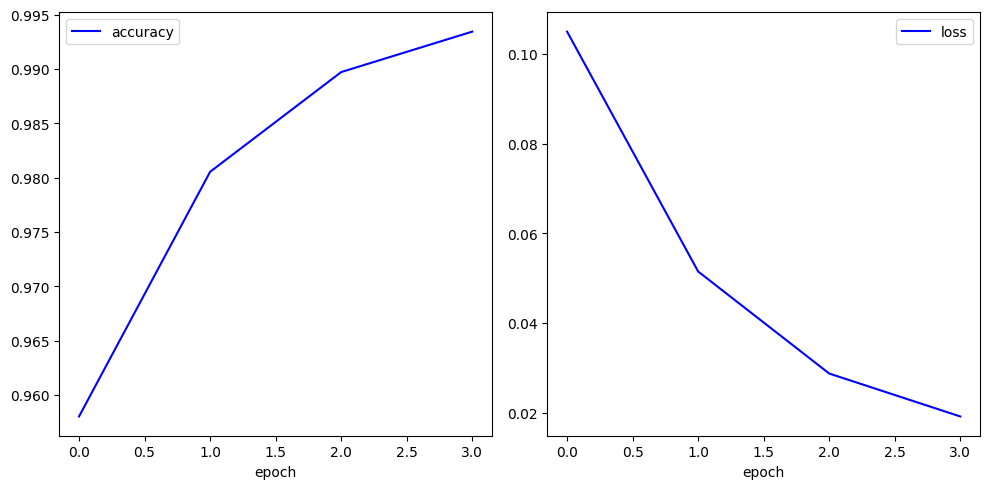

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.xlabel("epoch")
plt.plot(range(epochs), history_dict["sparse_categorical_accuracy"], label="accuracy", color="blue")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("epoch")
plt.plot(range(epochs), history_dict["loss"], label="loss", color="blue")

plt.legend()
plt.tight_layout()
plt.draw()


In [ ]:
with strategy.scope():
  classifier.compile()
  classifier.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 768),   │     109,482,240 │
│                                               │ pooled_output: (None, 768)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 109,483,778 (417.65 MB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)